
pip install -r requirements.txt
pip install pipwin
pipwin install -r requirements.txt

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
## Initial Imports

%matplotlib inline

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm_notebook as tqdm

#import lime
#import eli5
#import mlxtend
import warnings
warnings.filterwarnings('ignore')

**`Read data and Display data dimension`**

In [17]:
#pd_speech_features = pd.read_csv('pd_speech_features.csv')
pd_speech_features = pd.read_csv('/content/drive/My Drive/Paper work/Speech detection/pd_speech_features.csv')
#pd_speech_features = pd.read_csv(os.path.join(dirname,filename))
new_header = pd_speech_features.iloc[0] #grab the first row for the header
pd_speech_features = pd_speech_features[1:] #take the data less the header row
pd_speech_features.columns = new_header #set the header row as the df header
pd_speech_features.head()
print('The shape of the matrix is :', pd_speech_features.shape)

The shape of the matrix is : (756, 755)


#### Gather most general metadata about the data

In [18]:
pd_speech_features.info() # Gives type of columns
pd_speech_features.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 1 to 756
Columns: 755 entries, id to class
dtypes: object(755)
memory usage: 4.4+ MB


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,...,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756
unique,252,2,740,745,748,315,319,755,646,358,543,183,244,327,734,547,710,709,722,741,747,748,745,755,755,755,755,755,755,755,755,755,755,754,356,753,380,743,750,735,...,753,754,754,755,754,754,752,754,754,751,752,753,752,754,751,749,741,744,742,742,740,738,746,735,739,732,728,723,735,750,749,755,752,753,749,752,753,753,754,2
top,239,1,0.82273,0.75192,0.70689,237,236,0.006004477,6.29E-05,0.00076,1.39E-05,0.00012,0.00032,0.00036,0.03345,0.376,0.03125,0.05772,0.02824,0.03854,0.972537,0.005904,23.914,80.44328048,85.61022901,82.73382546,769.6772481,1279.806544,3107.527459,3738.070756,76.4915472,117.5349021,192.2014234,503.6803762,1,27.5848,0,0.93829,0.19121,0.13883,...,-3.3736,-0.09052,-8.9141,44.7366,15.7456,13.3637,11.8305,11.6205,11.573,3.5221,3.7508,5.6728,4.6953,11.6165,2.8016,3.2569,2.8667,3.7997,2.4181,2.5715,2.269,2.1762,2.2146,1.5932,1.8336,1.7484,2.3105,1.5899,1.6337,2.3955,3.58,4.0251,4.4021,3.3603,2.3974,3.1144,12.595,3.7708,10.0693,1
freq,3,390,3,2,2,9,8,2,3,9,10,24,14,11,2,5,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,385,2,377,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,2,3,3,2,3,2,2,2,2,2,2,2,2,2,2,564


In [19]:
pd_speech_features['patient/healthy count'] = 1
pd_speech_features.groupby('class').sum()/3

,patient/healthy count
class,
0,64.0
1,188.0


In [20]:
pd_speech_features = pd_speech_features.drop(['patient/healthy count'], axis = 1)  #756x755

All the data was imported in the object type, we now need to take care about the types in the dataframe

In [21]:
pd_speech_features =  pd_speech_features.astype(float) #per default all floats 
pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']] = pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']].astype(int) #ints
pd_speech_features[['gender', 'class']] = pd_speech_features[['gender', 'class']].astype('category') #categoricals
pd_speech_features.dtypes

0
id                              int64
gender                       category
PPE                           float64
DFA                           float64
RPDE                          float64
                               ...   
tqwt_kurtosisValue_dec_33     float64
tqwt_kurtosisValue_dec_34     float64
tqwt_kurtosisValue_dec_35     float64
tqwt_kurtosisValue_dec_36     float64
class                        category
Length: 755, dtype: object

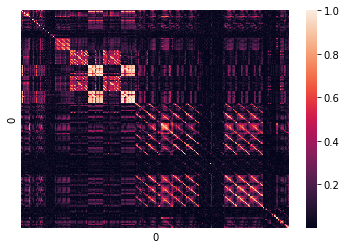

In [22]:
corr = pd_speech_features.corr() 

#too many variable to plot correlation matrix 
sns.heatmap(np.abs(corr), 
        xticklabels=[],
        yticklabels=[])

## Remove some corelated features 
In the paper it is suggested to remove the TQWT features 

In [23]:
pd_speech_features_no_tqwt = pd_speech_features[pd_speech_features.columns[1: -433]]
pd_speech_features_no_tqwt.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,...,app_LT_entropy_shannon_1_coef,app_LT_entropy_shannon_2_coef,app_LT_entropy_shannon_3_coef,app_LT_entropy_shannon_4_coef,app_LT_entropy_shannon_5_coef,app_LT_entropy_shannon_6_coef,app_LT_entropy_shannon_7_coef,app_LT_entropy_shannon_8_coef,app_LT_entropy_shannon_9_coef,app_LT_entropy_shannon_10_coef,app_LT_entropy_log_1_coef,app_LT_entropy_log_2_coef,app_LT_entropy_log_3_coef,app_LT_entropy_log_4_coef,app_LT_entropy_log_5_coef,app_LT_entropy_log_6_coef,app_LT_entropy_log_7_coef,app_LT_entropy_log_8_coef,app_LT_entropy_log_9_coef,app_LT_entropy_log_10_coef,app_LT_TKEO_mean_1_coef,app_LT_TKEO_mean_2_coef,app_LT_TKEO_mean_3_coef,app_LT_TKEO_mean_4_coef,app_LT_TKEO_mean_5_coef,app_LT_TKEO_mean_6_coef,app_LT_TKEO_mean_7_coef,app_LT_TKEO_mean_8_coef,app_LT_TKEO_mean_9_coef,app_LT_TKEO_mean_10_coef,app_LT_TKEO_std_1_coef,app_LT_TKEO_std_2_coef,app_LT_TKEO_std_3_coef,app_LT_TKEO_std_4_coef,app_LT_TKEO_std_5_coef,app_LT_TKEO_std_6_coef,app_LT_TKEO_std_7_coef,app_LT_TKEO_std_8_coef,app_LT_TKEO_std_9_coef,app_LT_TKEO_std_10_coef
1,1.0,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,1200445.612,...,-19278.0371,-25711.8622,-36938.1370,-57264.6625,-98433.1856,-184901.7535,-381059.3510,-776445.2329,-1676725.978,-3601122.613,414.6434,276.4850,198.5803,153.8978,132.2489,124.1971,127.9812,130.3804,140.7776,151.1748,0.86121,3.0487,9.7825,28.5949,74.3411,174.9214,371.7296,793.0680,1586.1824,3173.0448,6.2990,16.7003,42.0762,101.0889,228.8489,493.8563,1015.7707,2091.9460,4188.2456,8373.9278
2,1.0,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363615,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,1298455.445,...,-19028.6532,-25392.0069,-36496.8101,-56599.2563,-97324.8830,-182880.5032,-376979.9939,-768230.2335,-1659120.382,-3563560.603,413.5284,275.8597,198.1971,153.6379,132.0522,124.0327,127.8282,130.2373,140.6345,151.0317,0.85289,3.0213,9.6956,28.3506,73.7185,173.4666,368.5705,786.0763,1572.1837,3144.4525,6.2381,16.5376,41.7306,100.0918,226.9019,489.9169,1006.3702,2074.4541,4148.9889,8298.1606
3,1.0,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.15756,0.116890,1272869.841,...,-18926.4578,-25253.6144,-36288.7542,-56258.4752,-96708.1119,-181663.4768,-374463.8517,-763056.6385,-1648032.246,-3539902.400,413.0675,275.5868,198.0149,153.5036,131.9418,123.9329,127.7329,130.1464,140.5436,150.9408,0.84977,3.0062,9.6470,28.2014,73.3297,172.5204,366.5936,782.0604,1564.1081,3128.0295,6.2163,16.4817,41.4869,99.6154,225.7803,486.9865,1001.7348,2064.1067,4127.0967,8254.7868
4,0.0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98

In [24]:

train_df=pd_speech_features
train_df_tqwt=pd_speech_features_no_tqwt

y_train = train_df['class']
y_train = np.array(y_train.values, dtype = 'int')
x_train = train_df.drop(['class','id'], axis = 1) 

x_train = x_train.values
#y_validation = validation_df['class']
#y_validation = np.array(y_validation.values, dtype = 'int')
#x_validation = validation_df.drop(['class'], axis = 1) 

In [25]:
features=train_df.columns.values.tolist()
features.remove('id')
features.remove('class')
print(len(features))

753


In [26]:
print(x_train.shape)
print(y_train.shape)


(756, 753)
(756,)


In [27]:
from sklearn.linear_model import LogisticRegression

#from mlxtend.feature_selection import SequentialFeatureSelector

#selector = SequentialFeatureSelector(LogisticRegression(), forward=True, scoring='neg_log_loss', 
                                   #  verbose=2, k_features=10, forward=False, n_jobs=-1)

#selections=selector.fit(x_train, y_train)

In [28]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [29]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train= sc.fit_transform(x_train)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs_9 = SequentialFeatureSelector(LogisticRegression(random_state=10),n_features_to_select=9, n_jobs=-1)

sfs_9=sfs_9.fit(x_train, y_train)

In [ ]:
x_train_transformed_9_features=sfs_9.transform(x_train)
x_train_transformed_9_features.shape

(756, 9)

In [30]:
y_train_tqwt = y_train #train_df_tqwt['class']
#y_train_tqwt = np.array(y_train_tqwt.values, dtype = 'int')
x_train_tqwt = train_df_tqwt.values 

#y_validation_tqwt = validation_df_tqwt['class']
#y_validation_tqwt = np.array(y_validation_tqwt.values, dtype = 'int')
#x_validation_tqwt = validation_df_tqwt.drop(['class'], axis = 1) 

In [31]:
print(x_train_tqwt.shape)
print(y_train_tqwt.shape)

(756, 321)
(756,)


Note: If we remove all the outlier in all the columns, one could end up with a dataset which is too small in order to predict anything.

# LSTM

In [32]:
import keras
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import load_model
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [33]:
k_fold=KFold(10,True,10)

In [34]:
from sklearn import svm 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report


param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

In [35]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [37]:
HU=50
m=nn.Sequential(nn.Linear(HU,HU), nn.ReLU(),nn.Linear(HU,HU),nn.ReLU())

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(753,HU)
        self.l2=nn.Linear(HU,HU)
        self.l3=nn.Linear(HU,HU)
        self.ll=m
        self.l4=nn.Linear(HU,1)
        
    def forward(self,x):
        x=self.l1(x)
        x=F.relu(F.dropout(x,0.20))
        x1=self.l2(x)
        #x2=F.relu(F.dropout(x1,0.20))
        x=self.l3(x1)
        x2=self.ll((x+x1)/2.00)
        x=F.relu(F.dropout(x2,0.20))
        x=self.ll((x))
        #x=self.l3(x)
        x3=F.relu(F.dropout((x+x1+x2)/3.0,0.200))
        x=self.l4(x3)
        
        return x

In [38]:
#model=lstm_model#Model()
#model=model
model=Model()
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.6,momentum=0.99, nesterov=False)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=(.2))

In [40]:
#x=torch.from_numpy(x_train_transformed_9_features[:600]).float()
x=torch.from_numpy(x_train[:600]).float()
y=torch.from_numpy(y_train[:600]).float()

def train(model,optimizer, scheduler, criterion, x,y):
    
    losses=[]
    
    for i in range(100):
        output=model(x)
        loss=criterion(output.view(y.shape[0]),y)
    
        losses.append(loss)
    
        #if (i%100==0):
         #   print(i,' ',loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # training accuracy
    with torch.no_grad():
        preds=torch.sigmoid(model(x)).round()
        print('\ntraining report: \n',classification_report(y,preds.view(preds.shape[0])))
        
    return model, losses

model, losses= train(model,optimizer, scheduler, criterion,x,y)


training report: 
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       141
         1.0       0.99      0.99      0.99       459

    accuracy                           0.99       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.99      0.99      0.99       600



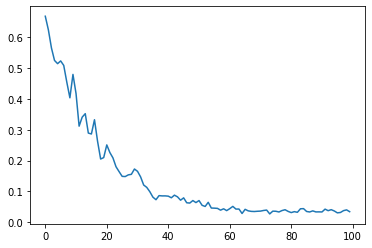

In [41]:
%matplotlib inline
plt.plot(losses)
plt.show()

In [46]:
def test(model, tstx, tsty):
    with torch.no_grad():
    
        preds=torch.sigmoid(model(tstx)).round()
        print('testing report:')
        print(classification_report(tsty,preds.view(preds.shape[0])))
    
    
    
        print(torch.sigmoid(preds).round().shape)

In [47]:
#tstx=torch.from_numpy(x_train_transformed_9_features[600:]).float()
tstx=torch.from_numpy(x_train[600:]).float()
tsty=torch.from_numpy(y_train[600:]).float()

test(model,tstx,tsty)

testing report:
              precision    recall  f1-score   support

         0.0       0.58      0.63      0.60        51
         1.0       0.81      0.78      0.80       105

    accuracy                           0.73       156
   macro avg       0.70      0.70      0.70       156
weighted avg       0.74      0.73      0.73       156

torch.Size([156, 1])


In [48]:
x_train.shape

(756, 753)

In [49]:
def run_network(model, trainx,trainy, testx, testy):
    model=Model()
    criterion = nn.BCEWithLogitsLoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=0.6,momentum=0.99, nesterov=True)
    #optim=torch.optim.Adam(model.parameters(),lr=0.1)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
    model, losses= train(model,optimizer, scheduler, criterion,trainx, trainy)
    test(model, testx, testy)
    
    return model, losses

In [52]:
fold=0
losses=[[] for i in range(10)]

for trids, tstids in k_fold.split(x_train):
    trainx, testx=x_train[trids,:], x_train[tstids,:]
    #trainx, testx=x_train[trids,:], x_train[tstids,:]
    trainy, testy=y_train[trids], y_train[tstids]
    
    trainx=torch.from_numpy(trainx).float()
    trainy=torch.from_numpy(trainy).float()
    testx=torch.from_numpy(testx).float()
    testy=torch.from_numpy(testy).float()
    
    print('fold: ',fold)
    
    model=Model()
    
    _,losses[fold]=run_network(model, trainx,trainy, testx,testy)
    
    fold=fold+1




fold:  0

training report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       178
         1.0       1.00      1.00      1.00       502

    accuracy                           1.00       680
   macro avg       1.00      1.00      1.00       680
weighted avg       1.00      1.00      1.00       680

testing report:
              precision    recall  f1-score   support

         0.0       0.78      0.50      0.61        14
         1.0       0.90      0.97      0.93        62

    accuracy                           0.88        76
   macro avg       0.84      0.73      0.77        76
weighted avg       0.87      0.88      0.87        76

torch.Size([76, 1])
fold:  1

training report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       172
         1.0       1.00      1.00      1.00       508

    accuracy                           1.00       680
   macro avg       1.00      1.00 

(0.0, 1.0)

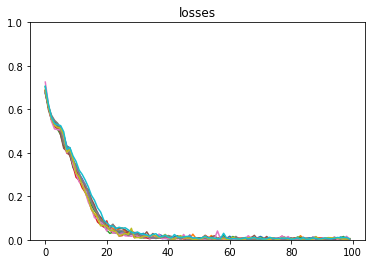

In [54]:
for i in range(10):
  plt.plot(losses[i])
plt.title('losses')
plt.ylim(0.0,1)